In [46]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split

import utils as u
from models import pentzer2014pow
from models.ML import terrain_RF as trf
from visualization import multiline, papermode

# papermode(plt, size=12)

In [2]:
ugv_name = "husky"
saved_path = Path("data") / "saved_models"
model_name = trf.TerrainRFRegressor.model_name().lower()
figdir = u.get_figdir("summary", subdir=model_name)
model_name = trf.TerrainRFRegressor.filename()
ugv_mdl_path = saved_path / model_name / ugv_name

In [3]:
# terrain_abbrs = u.import_terrain_abbrs_yaml(("Till", "Vegetal", "Asphalt", "Snow"))
terrain_abbrs = u.import_terrain_abbrs_yaml(
    ("Sandy loam", "Asphalt", "Snow", "Flooring", "Ice")
)
terrain_abbrs = {
    terr: [abbr for abbr in terr_abbrs if u.get_ugv(abbr) == "husky"]
    for terr, terr_abbrs in terrain_abbrs.items()
}
# terrain_abbrs = u.import_terrain_abbrs_yaml()
abbrs = sorted([item for sublist in terrain_abbrs.values() for item in sublist])
# abbrs = [abbr for abbr in abbrs if u.get_ugv(abbr) == "husky"]

In [4]:
dfs = {}
for abbr in abbrs:
    pentz_df = pentzer2014pow.open_model_df(abbr)
    dfs[abbr] = pentz_df
    dfs[abbr]["mass"] = pentz_df.meta.ugv_mass
    dfs[abbr]["terrain"] = u.get_terrain(abbr).lower()

In [5]:
# veloc = ("vx", "vy", "vz")
veloc = ("vx",)
accel_cor = ("ax_corr", "ay_corr", "az_corr")
posit = ("px", "py", "pz")
volts = ("V_L", "V_R")
wheel = ("vL", "vR")
morales = ("JS_sym", "JG")
amps = ("I_L", "I_R")

# cols_x = [
#     # "mass",
#     *veloc,
#     *accel_cor,
#     # *posit,
#     *volts,
#     *wheel,
#     *morales,
#     *amps,
# ]

cols_x = [
    *veloc,
    *accel_cor,
    *volts,
    *wheel,
    *morales,
    *amps,
]

cols_y = ["P_motion", "terrain"]

In [6]:
terrain_dfs = {}
for terr, terr_abbrs in terrain_abbrs.items():
    terr_dfs = [dfs[abbr] for abbr in terr_abbrs]
    terrain_dfs[terr] = pd.concat(terr_dfs, ignore_index=True)
    terrain_dfs[terr]["terrain"] = terr

terr_df = pd.concat(terrain_dfs.values(), ignore_index=True)
terr_df = terr_df[cols_x + cols_y].copy().dropna()

In [7]:
X = terr_df[cols_x].copy()
y = terr_df[cols_y].copy()
terrain_summary = y.terrain.value_counts()
terrains = sorted(terrain_dfs.keys())
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
terrain_summary

ice           14849
flooring      13924
snow           9378
sandy loam     4347
asphalt        3695
Name: terrain, dtype: int64

# Model

In [9]:
if False:
    ter_rf = trf.TerrainRFRegressor.from_files(ugv_mdl_path)
else:
    ter_rf = trf.TerrainRFRegressor(terrains=terrains)
    ter_rf.fit(X_train, y_train)

Snow: 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]      


In [10]:
y_pred = ter_rf.predict(X_test, y_test.P_motion)
ter_rf.score(X_test, y_test)

0.7237856091436488

# Metrics

In [11]:
y_true = y_test.terrain
y_pred = ter_rf.predict(X_test, y_test.P_motion)
metrics = ter_rf.metrics(y_true, y_pred)
print(metrics)
pow_metrics = ter_rf.power_metrics(X_test, y_test)
print(pow_metrics)

Exporting metrics to /home/damien/code/norlab/terrain-power/terrain-code/metrics_ML.json
accuracy                                              0.723786
precision    [0.5516252390057361, 0.8288204170557112, 0.785...
recall       [0.6368653421633554, 0.7696531791907515, 0.782...
f1-score     [0.591188524590164, 0.7981417653229432, 0.7836...
dtype: object
Exporting metrics to /home/damien/code/norlab/terrain-power/terrain-code/metrics_ML.json
asphalt       0.933477
flooring      0.985060
ice           0.973670
sandy loam    0.976376
snow          0.974068
dtype: float64


['vx', 'ax_corr', 'ay_corr', 'az_corr', 'V_L', 'V_R', 'vL', 'vR', 'JS_sym', 'JG', 'I_L', 'I_R']


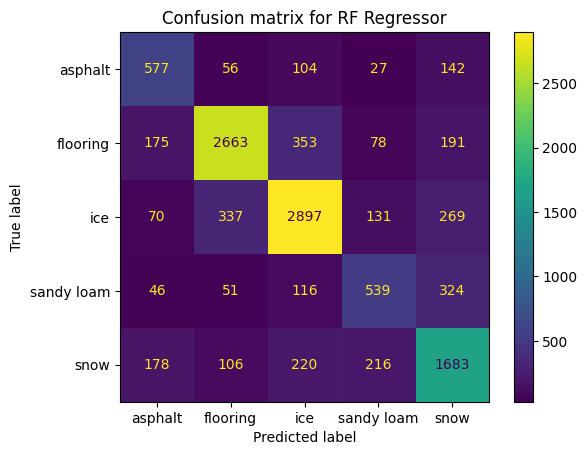

In [12]:
disp = ter_rf.confusion_matrix(y_test.terrain, y_pred)
print(cols_x)

['vx', 'ax_corr', 'ay_corr', 'az_corr', 'V_L', 'V_R', 'vL', 'vR', 'JS_sym', 'JG', 'I_L', 'I_R']


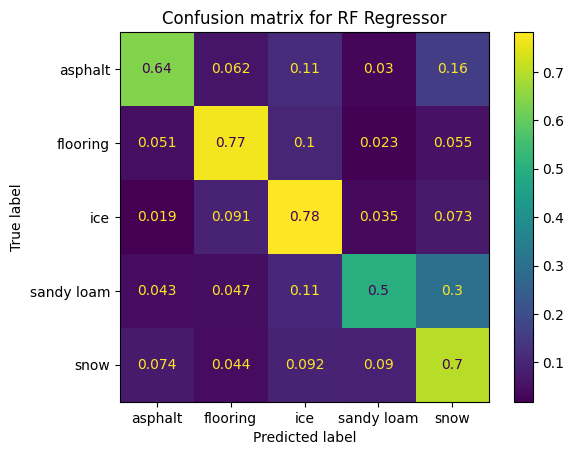

In [13]:
disp = ter_rf.confusion_matrix(
    y_test.terrain, y_pred, normalization="true", figdir=figdir
)
print(cols_x)

In [14]:
pred_proba = ter_rf.predict_proba(X_test, y_test.P_motion)
for terr in pred_proba.columns.values:
    errabs = pred_proba[terr].abs()
    print(terr)
    print("min", errabs.min(), errabs.argmin())
    print("max", errabs.max(), errabs.argmax())

asphalt
min 0.0 72
max 170.25964545768628 4861
flooring
min 0.0 72
max 310.2527968371169 4861
ice
min 0.0 72
max 200.54089658827368 4861
sandy loam
min 1.4210854715202004e-14 9871
max 227.84106162783763 9176
snow
min 0.0 72
max 156.00527265763782 4861


In [15]:
ter_rf.export_models(ugv_mdl_path)

Exporting models in /home/damien/code/norlab/terrain-power/terrain-code/data/saved_models/rf-regressor/husky


In [16]:
y_test = y_test.reset_index(drop=True)

Text(0, 0.5, 'Power prediction error')

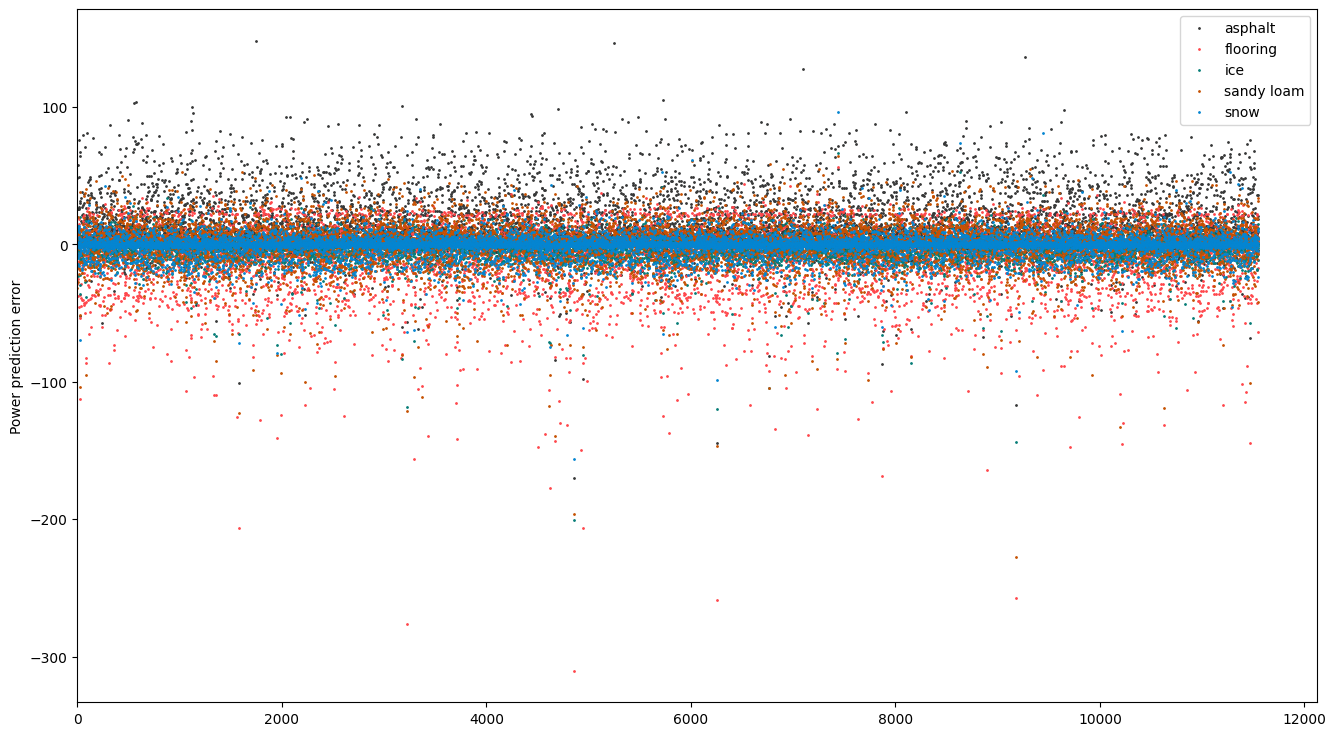

In [17]:
fig, ax = plt.subplots(figsize=(16, 9))

# ax.plot(y_test.index, y_test.P_motion, marker="o", linestyle="", markersize=2, label="Real", color="xkcd:red")

for terr in pred_proba.columns.values:
    ax.plot(
        y_test.index,
        pred_proba[terr],
        marker="o",
        linestyle="",
        markersize=1,
        label=terr,
        color=u.COLORS[terr],
    )

ax.legend()
# ax.set_ylim(bottom=-100, top=100)
ax.set_xlim(left=0)
ax.set_ylabel("Power prediction error")

Text(0, 0.5, 'Power prediction error (%)')

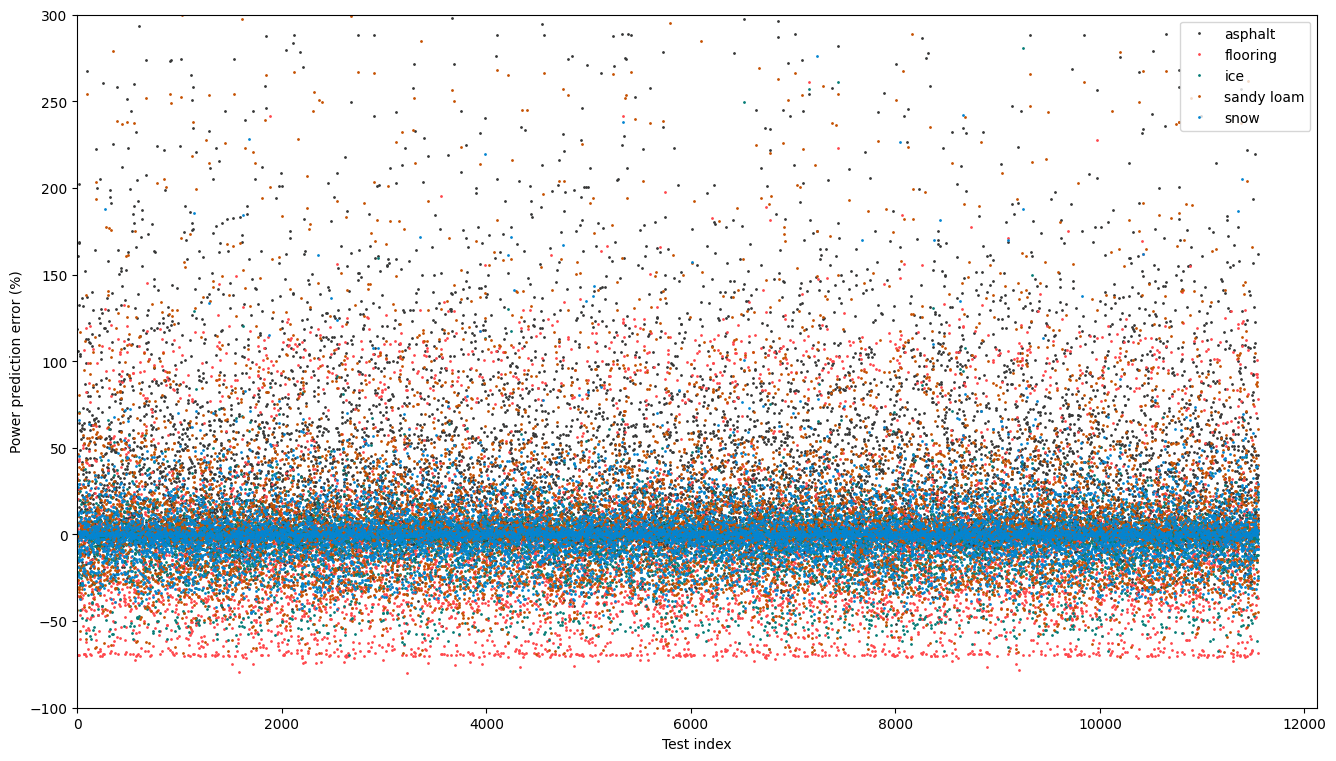

In [18]:
fig, ax = plt.subplots(figsize=(16, 9))

# ax.plot(y_test.index, y_test.P_motion, marker="o", linestyle="", markersize=2, label="Real", color="xkcd:red")

for terr in pred_proba.columns.values:
    power_pred_err = pred_proba[terr] / y_test.P_motion * 100
    ax.plot(
        y_test.index,
        power_pred_err,
        marker="o",
        linestyle="",
        markersize=1,
        label=terr,
        color=u.COLORS[terr],
    )

ax.legend()
ax.set_ylim(bottom=-100, top=300)
ax.set_xlim(left=0)
ax.set_xlabel("Test index")
ax.set_ylabel("Power prediction error (%)")

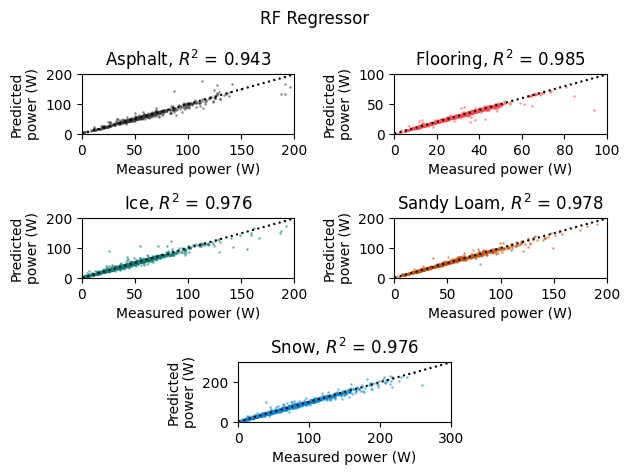

In [59]:
layout = [
    ["asphalt", "asphalt", "flooring", "flooring"],
    ["ice", "ice", "sandy loam", "sandy loam"],
    [".", "snow", "snow", "."],
]
fig, subfigs = plt.subplot_mosaic(mosaic=layout)

power_pred = ter_rf.predict_power(X_test)

limits = {
    "asphalt": 200,
    "flooring": 100,
    "ice": 200,
    "sandy loam": 200,
    "snow": 300,
}

for terr in power_pred.columns.values:
    ax = subfigs[terr]
    terr_idx = y_test.terrain == terr
    P_pred = power_pred[terr][terr_idx]
    P_meas = y_test.P_motion[terr_idx]
    ax.plot(
        P_meas,
        P_pred,
        marker="o",
        linestyle="",
        markersize=1,
        label=terr,
        color=u.COLORS[terr],
        alpha=0.4,
    )
    xmax = limits[terr]
    ymax = ax.get_xlim()[1]
    line = [0, ymax]
    ax.plot(line, line, ":k", label="Measure = Prediction")

    # ax.set_aspect("equal")
    r_squared = r2_score(P_meas, P_pred)

    ax.set_xlabel("Measured power (W)")
    ax.set_ylabel("Predicted\npower (W)")
    ax.set_title(f"{terr.title()}, $R^2$ = {r_squared:.3f}")

    ax.set_xlim(left=0, right=xmax)
    ax.set_ylim(bottom=0, top=xmax)

fig.suptitle(ter_rf.display_name())
fig.tight_layout()

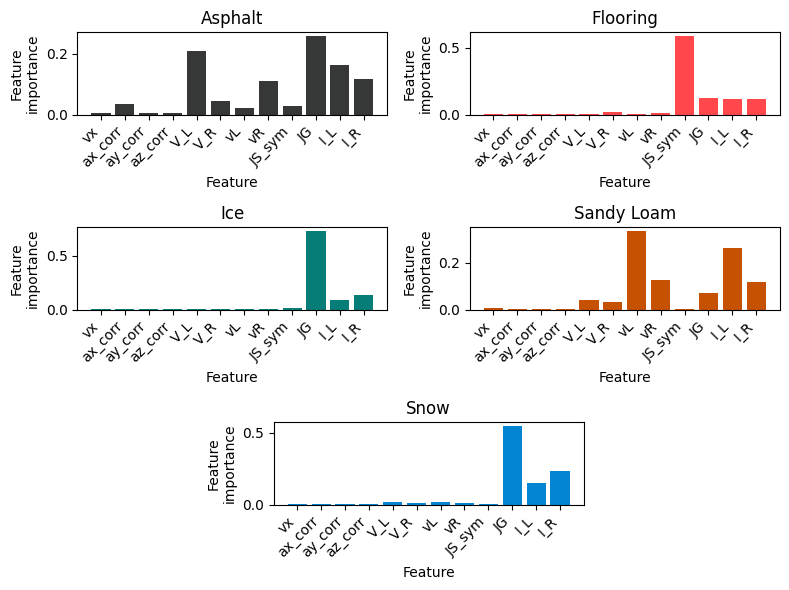

In [20]:
layout = [
    ["asphalt", "asphalt", "flooring", "flooring"],
    ["ice", "ice", "sandy loam", "sandy loam"],
    [".", "snow", "snow", "."],
]
fig, subfigs = plt.subplot_mosaic(mosaic=layout, figsize=(8, 6))

for idx, terr in enumerate(power_pred.columns.values):
    ax = subfigs[terr]
    mdl = ter_rf.models[idx]
    ax.bar(X_test.columns.values, mdl.feature_importances_, color=u.COLORS[terr])
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xlabel("Feature")
    ax.set_ylabel("Feature\nimportance")
    ax.set_title(f"{terr.title()}")
fig.tight_layout()

In [21]:
if False:
    cross_val_score(ter_rf, X, y)

# Unseen data

In [22]:
unseen = pentzer2014pow.open_model_df("H74")
unseen["mass"] = unseen.meta.ugv_mass
unseen = unseen[cols_x + ["P_motion", "time_rel"]].copy().dropna()
unseen = unseen.dropna()

In [23]:
print(unseen.shape)
unseen.head()

(6290, 14)


vx   ax_corr   ay_corr   az_corr    V_L    V_R        vL  \
0 -2.254265e-16 -0.978097 -0.007367  0.049040  23.16  23.16  0.055118   
1  3.561989e-03 -1.104764 -0.102631  0.047878  23.06  22.99  0.173228   
2  2.780546e-02 -0.546486 -0.090610 -0.066458  22.92  22.92  0.220472   
3  3.611061e-02  0.482854  0.093764  0.075668  23.16  23.16  0.220472   
4  4.441576e-02 -0.053227 -0.068949 -0.015779  23.13  23.09  0.220472   

         vR    JS_sym        JG   I_L   I_R   P_motion  time_rel  
0  0.055118  3.332478  0.110236  0.00  5.19   5.334564  0.000000  
1  0.173228  1.733511  0.346457  1.64  6.76  27.135356  0.160083  
2  0.236220  1.085047  0.456693  1.91  6.37  35.913232  0.271713  
3  0.244094  3.731143  0.464567  0.00  3.88  17.661475  0.383233  
4  0.244094  2.310931  0.464567  0.00  4.01  18.253226  0.527148

In [24]:
X_unseen = unseen[cols_x].copy()
P_unseen = unseen.P_motion.copy()
pred_unseen = ter_rf.predict_idx(X_unseen, P_unseen)
pred_unseen

array([2, 4, 2, ..., 1, 1, 2])

In [25]:
y_unseen = ter_rf.predict(X_unseen, P_unseen)

In [26]:
X_unseen.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            6340, 6341, 6342, 6343, 6344, 6345, 6346, 6347, 6348, 6349],
           dtype='int64', length=6290)

Text(0.5, 0, 'Elapsed time (s)')

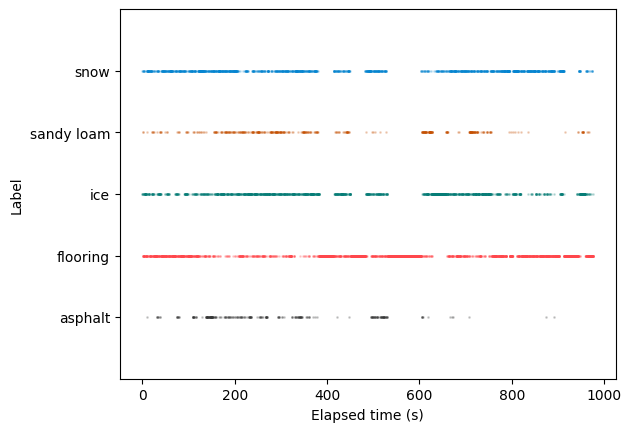

In [34]:
fig, ax = plt.subplots()

for idx, terr in enumerate(ter_rf.terrains):
    terr_idx = y_unseen == terr
    terr_time = unseen.time_rel.loc[terr_idx]
    terr_label = idx * np.ones(terr_time.shape)
    ax.plot(
        terr_time,
        terr_label,
        marker="o",
        linestyle="",
        markersize=1,
        label=terr,
        color=u.COLORS[terr],
        alpha=0.2,
    )

ax.set_yticks(np.arange(ter_rf.len_classes()), ter_rf.terrains)

ax.set_ylim(bottom=-1, top=ter_rf.len_classes())
ax.set_ylabel("Label")
ax.set_xlabel("Elapsed time (s)")

In [28]:
err = ter_rf.APE(X_unseen, unseen)
err.head()

asphalt  flooring       ice  sandy loam      snow
0  3.910438  1.440306  0.355841    1.454321  1.074247
1  0.545241  0.272307  0.287141    0.392688  0.236815
2  0.292047  0.073730  0.015713    0.052239  0.060499
3  1.571142  0.029828  0.109476    0.535731  0.210949
4  1.522323  0.013729  0.091750    0.686559  0.211018

Text(0.5, 0, 'Elapsed time (s)')

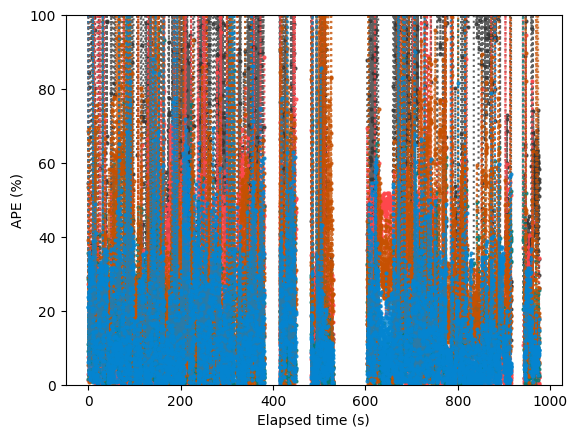

In [35]:
fig, ax = plt.subplots()

for terr in err.columns.values:
    ax.plot(
        unseen.time_rel,
        err[terr] * 100,
        marker="o",
        linestyle=":",
        markersize=2,
        label=terr,
        color=u.COLORS[terr],
        alpha=0.8,
    )

# ax.set_yticks(np.arange(ter_rf.len_classes()), ter_rf.terrains)

ax.set_ylim(bottom=0, top=100)
ax.set_ylabel("APE (%)")
ax.set_xlabel("Elapsed time (s)")

Text(0.5, 0, 'Elapsed time (s)')

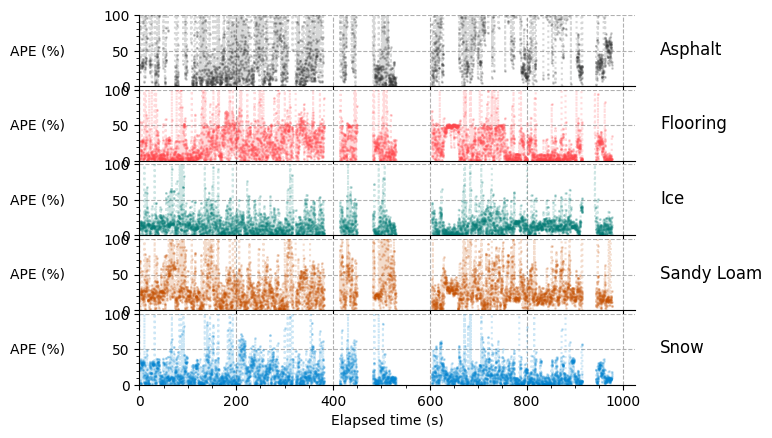

In [57]:
fig, axs = plt.subplots(nrows=ter_rf.len_classes(), gridspec_kw={"hspace": 0.05})


for ax in axs[:-1]:
    ax.set_xticklabels([])

for ax, terr in zip(axs, err.columns.values):
    ax.plot(
        unseen.time_rel,
        err[terr] * 100,
        marker="o",
        linestyle=":",
        markersize=1,
        label=terr,
        color=u.COLORS[terr],
        alpha=0.2,
    )
    ax.set_ylim(bottom=0, top=100)
    ax.set_xlim(left=0)

    ax.grid("on", linestyle="--")
    ax.set_ylabel("APE (%)", rotation=0, ha="right", va="center")
    ax.set_title(terr.title(), ha="left", va="center", y=0.4, x=1.05)

    ax.spines[["right", "top"]].set_visible(False)
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_label_coords(-0.15, 0.5)

axs[-1].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axs[-1].xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%g"))
axs[-1].set_xlabel("Elapsed time (s)")